In [1]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,EarlyStopping
import numpy as np
import librosa
from keras.callbacks import ReduceLROnPlateau
import glob
import random
from scipy.io import wavfile
from IPython.display import Audio, Image
import matplotlib.pyplot as plt

In [2]:
# Define YAMNet model
yamnet_model_handle = "https://tfhub.dev/google/yamnet/1"
yamnet_model = hub.load(yamnet_model_handle)
yamnet_model.trainable = True

In [3]:
data_dir = 'small_birds_dataset'

bird_code_to_name = {
  'wbwwre1': 'White-breasted Wood-Wren',
  'houspa': 'House Sparrow',
  'redcro': 'Red Crossbill',  
  'chcant2': 'Chestnut-crowned Antpitta',
  'azaspi1': "Azara's Spinetail",   
}

birds_images = {
  'wbwwre1': 'https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg/640px-Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg', #   Alejandro Bayer Tamayo from Armenia, Colombia 
  'houspa': 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/52/House_Sparrow%2C_England_-_May_09.jpg/571px-House_Sparrow%2C_England_-_May_09.jpg', #    Diliff
  'redcro': 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Red_Crossbills_%28Male%29.jpg/640px-Red_Crossbills_%28Male%29.jpg', #  Elaine R. Wilson, www.naturespicsonline.com
  'chcant2': 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Chestnut-crowned_antpitta_%2846933264335%29.jpg/640px-Chestnut-crowned_antpitta_%2846933264335%29.jpg', #   Mike's Birds from Riverside, CA, US
  'azaspi1': 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Synallaxis_azarae_76608368.jpg/640px-Synallaxis_azarae_76608368.jpg', # https://www.inaturalist.org/photos/76608368
}

test_files = os.path.abspath(os.path.join(data_dir, 'test/*/*.wav'))

def get_random_audio_file():
  test_list = glob.glob(test_files)
  random_audio_path = random.choice(test_list)
  return random_audio_path


def show_bird_data(audio_path):
    sample_rate, audio_data = wavfile.read(audio_path)

    # Use the correct path separator based on the operating system
    bird_code = os.path.basename(os.path.dirname(audio_path))

    print(f'Bird name: {bird_code_to_name.get(bird_code, "Unknown")}')
    print(f'Bird code: {bird_code}')
    display(Image(birds_images.get(bird_code, 'Unknown')))

    plttitle = f'{bird_code_to_name.get(bird_code, "Unknown")} ({bird_code})'
    plt.title(plttitle)
    plt.plot(audio_data)
    display(Audio(audio_data, rate=sample_rate))


print('functions and data structures created')

functions and data structures created


Bird name: Red Crossbill
Bird code: redcro


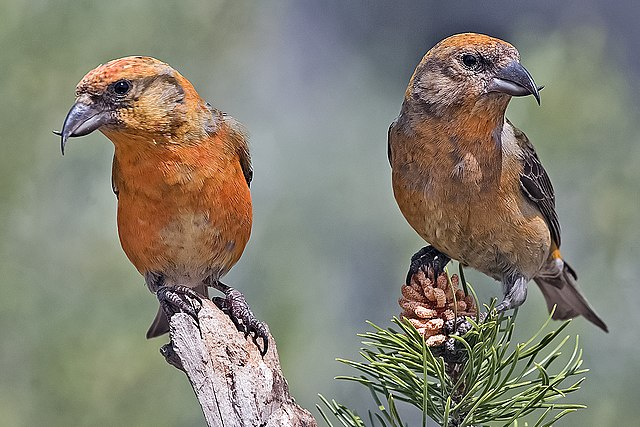

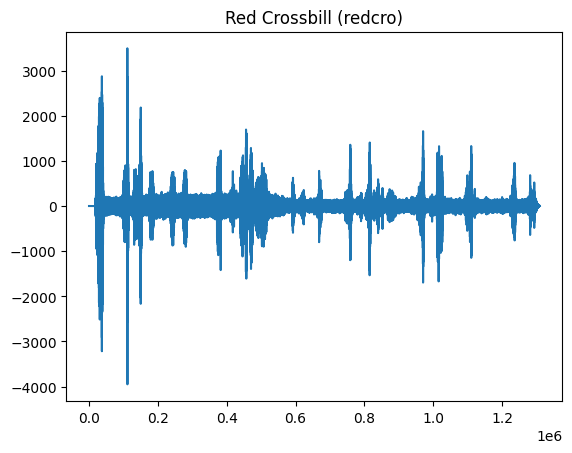

In [8]:
random_audio = get_random_audio_file()
show_bird_data(random_audio)

In [4]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [5]:
# Load your Birds dataset
birds_csv = 'small_birds_dataset/metadata.csv'
base_data_path = 'small_birds_dataset'

# Read CSV with the provided column names
pd_data = pd.read_csv(birds_csv)

# Define your classes and map class to ID
my_classes = ['White-breasted Wood-Wren', 'House Sparrow', 'Red Crossbill', 'Chestnut-crowned Antpitta', 'Azara\'s Spinetail']
map_class_to_id = {bird_class: idx for idx, bird_class in enumerate(my_classes)}

# Filter the dataframe based on your classes
filtered_pd = pd_data[pd_data['common_name'].isin(my_classes)]

# Map bird species to class ID
class_id = filtered_pd['common_name'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

# Create full paths for audio files
full_path = filtered_pd.apply(lambda row: os.path.join(base_data_path, row['split'], row['primary_label'], row['filename']), axis=1)
filtered_pd = filtered_pd.assign(filename=full_path)

# Display the modified dataframe
filtered_pd.head(10)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url,duration,split,target
0,azaspi1,[],['song'],8.7171,-71.33040,Synallaxis azarae,Azara's Spinetail,Joe Klaiber,0000-00-00,small_birds_dataset\train\azaspi1\XC219896.wav,Creative Commons Attribution-NonCommercial-Sha...,5.0,00:00,https://www.xeno-canto.org/219896,9.682,train,4
1,azaspi1,[],['song'],-0.4400,-77.86240,Synallaxis azarae,Azara's Spinetail,GABRIEL LEITE,2014-07-11,small_birds_dataset\train\azaspi1\XC186641.wav,Creative Commons Attribution-NonCommercial-Sha...,5.0,11:00,https://www.xeno-canto.org/186641,12.304,train,4
2,azaspi1,[],['song'],-17.1528,-65.90840,Synallaxis azarae,Azara's Spinetail,Sjoerd Mayer,1992-08-28,small_birds_dataset\train\azaspi1\XC1596.wav,Creative Commons Attribution-NonCommercial-Sha...,5.0,?,https://www.xeno-canto.org/1596,12.862,train,4
3,azaspi1,[],['song'],-4.6476,-79.74426,Synallaxis azarae,Azara's Spinetail,Willem-Pier Vellinga,2000-07-00,small_birds_dataset\test\azaspi1\XC746.wav,Creative Commons Attribution-NonCommercial-Sha...,4.5,?:?,https://www.xeno-canto.org/746,14.358,test,4
4,azaspi1,[],['song'],1.6564,-76.18300,Synallaxis azarae,Azara's Spinetail,David Bradley,2015-12-26,small_birds_dataset\train\azaspi1\XC298616.wav,Creative Commons Attribution-NonCommercial-Sha...,5.0,06:00,https://www.xeno-canto.org/298616,14.780,train,4
5,azaspi1,[],['song'],-23.6738,-64.90040,Synallaxis azarae,Azara's Spinetail,Richard Dunn,2016-10-19,small_birds_dataset\train\azaspi1\XC345968.wav,Creative Commons Attribution-NonCommercial-Sha...,5.0,08:00,https://www.xeno-canto.org/345968,15.114,train,4
6,azaspi1,[],['song'],-2.6000,-78.70000,Synallaxis azarae,Azara's Spinetail,Bob Planqué,2002-08-12,small_birds_dataset\test\azaspi1\XC9.wav,Creative Commons Attribution-NonCommercial-Sha...,5.0,7:00,https://www.xeno-canto.org/9,16.812,test,4
7,azaspi1,[],['song'],-5.9104,-78.42680,Synallaxis azarae,Azara's Spinetail,Jorge Tiravanti,2008-05-10,small_birds_dataset\train\azaspi1\XC123916.wav,Creative Commons Attribution-NonCommercial-Sha...,5.0,06:00,https://www.xeno-canto.org/123916,16.840,train,4
8,azaspi1,[],['song'],-13.1667,-72.55010,Synallaxis azarae,Azara's Spinetail,Niels Krabbe,1983-07-05,small_birds_dataset\test\azaspi1\XC47794.wav,Creative Commons Attribution-NonCommercial-Sha...,5.0,.,https://www.xeno-canto.org/47794,17.094,test,4
9,azaspi1,[],['song'],-4.1170,-80.06700,Synallaxis azarae,Azara's Spinetail,John V. Moore,1999-03-00,small_birds_dataset\train\azaspi1\XC258105.wav,Creative Commons Attribution-NonCommercial-Sha...,5.0,?,https://www.xeno-canto.org/258105,17.354,train,4


In [11]:

from sklearn.model_selection import train_test_split
# Create TensorFlow Dataset for training
train_filenames, val_filenames, train_targets, val_targets = train_test_split(
    filtered_pd[filtered_pd['split'] == 'train']['filename'], filtered_pd[filtered_pd['split'] == 'train']['target'], test_size=0.2, random_state=42)

def load_wav_for_map_train(filename, label):
    return load_wav_16k_mono(filename), label

def load_wav_for_map_val(filename, label):
    return load_wav_16k_mono(filename), label

train_ds = tf.data.Dataset.from_tensor_slices((train_filenames, train_targets))
val_ds = tf.data.Dataset.from_tensor_slices((val_filenames, val_targets))

train_ds = train_ds.map(load_wav_for_map_train)
val_ds = val_ds.map(load_wav_for_map_val)

# Create TensorFlow Dataset for testing
test_filenames = filtered_pd[filtered_pd['split'] == 'test']['filename']
test_targets = filtered_pd[filtered_pd['split'] == 'test']['target']

test_ds = tf.data.Dataset.from_tensor_slices((test_filenames, test_targets))

# Load WAV data for mapping
def load_wav_for_map_test(filename, label):
    return load_wav_16k_mono(filename), label

test_ds = test_ds.map(load_wav_for_map_test)
test_ds.element_spec

# Extract embeddings
def extract_embedding(wav_data, label):
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings))

# Apply embedding extraction to training dataset
train_ds = train_ds.map(extract_embedding).unbatch()
train_ds.element_spec

val_ds = val_ds.map(extract_embedding).unbatch()
val_ds.element_spec

# Apply embedding extraction to testing dataset
test_ds = test_ds.map(extract_embedding).unbatch()
test_ds.element_spec

# Cache the datasets
cached_train_ds = train_ds.cache()
cached_val_ds=val_ds.cache()
cached_test_ds = test_ds.cache()

# Shuffle, batch, and prefetch the datasets
train_ds = cached_train_ds.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = cached_test_ds.batch(32).prefetch(tf.data.AUTOTUNE)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
# Define your model
my_model = Sequential([
    Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Increase dropout rate
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Increase dropout rate
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # Keep dropout rate lower
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # Keep dropout rate lower
    Dense(len(my_classes), activation='softmax')
], name='my_model')

my_model.summary()

# Compile the model with a lower learning rate
my_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=Adam(learning_rate=0.001),
                 metrics=['accuracy'],)


# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1,    
                              patience=5,    
                              min_lr=1e-5) 

callback = EarlyStopping(monitor='loss',
                         patience=5,
                         restore_best_weights=True)

# Batch size and steps per epoch
batch_size = 32 # Increase batch size
total_samples = len(train_filenames)
steps_per_epoch = total_samples // batch_size

# Train the model with specified steps_per_epoch and validation set
history = my_model.fit(train_ds,
                       epochs=50,
                       steps_per_epoch=steps_per_epoch,
                       validation_data=val_ds,
                       callbacks=[reduce_lr]
                       )



Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 529,413
Trainable params: 528,389
Non-trainable params: 1,024
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 1s 68ms/step - loss: 1.3311 - accuracy: 0.5625 - val_loss: 1.6915 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - 0s 51ms/step - loss: 0.9148 - accuracy: 0.71

In [13]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

      1/Unknown - 0s 8ms/step - loss: 0.8668 - accuracy: 0.6875181/181 [==============================] - 0s 2ms/step - loss: 0.8253 - accuracy: 0.6946
Loss:  0.8252915740013123
Accuracy:  0.6945505142211914


In [14]:
my_model.save("birds_audio_model.h5")